In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
get_ipython().run_line_magic('matplotlib', 'inline')


 # Introduction
 This data summarizes behaviors of wholesale customers: clients of a wholesale
 distributor. It describes the annual spending on products in these categories:
 * Fresh food
 * Milk
 * Groceries
 * Frozen
 * Detergents and paper products
 * Delicatessen

 It also includes these categorical fields:
 * Channel: Hotel/Restaurant/Cafe or Retail
 * Region: Lisnon, Oporto, or Other

 More information about the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# Import the data
data = pd.read_csv("wholesale.csv")
data.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


 # K-means clustering
 ## The Algorithm
 The K-means algorithms works by selecting $k$ random centers, then assigning
 each point to the cluster whose center it is nearest to. Then, the centers are
 recalculated as the mean of the points nearest to them, and the process
 repeats. This algorithm is particularly good for large datasets, thanks to its
 O(n^2) time complexity. However, it is subsceptible to its (randomly assigned)
 starting state, so many implementations of K-means will run the algorithm
 multiple times with different starting configurations. The sklearn
 implementation that we use here runs the algorithm with 8 different initial
 conditions.

 ## Choosing K
 It's important when constructing a K-means model to select an appropriate
 value for $k$ in the context of the data set. Categorizing into too few
 clusters will decrease the accuracy of our model, but by using too many
 clusters, we can generate clusters that are almost impossible to interpret.

 Fortunately, because it's a relatively fast algorithm, we can run it with a
 number of different $k$ values and compare the results using a
 sum-squared-error metric to determine what number of clusters achieves the
 right balance. We can visualize the trade-off with an elbow plot, which shows
 the accuracy of the model at each $k$.

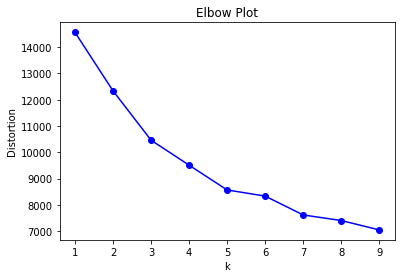

In [3]:
# Select n
distortions = []
K = range(1,10)
for k in K:
    model = KMeans(n_clusters=k).fit(data)
    model.fit(data)
    distortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

plt.plot(K, distortions, 'bo-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Plot')
plt.show()


 The elbow plot shows that we should choose n between 3 and 5. In this
 particular case, we will use 3 clusters for the sake of simplicity.

 Below, we construct 3 K-means clusters of the data.

In [4]:
# Build clusters
k = 3
colors = ["red", "green", "blue"]

model = KMeans(n_clusters=k, random_state=236)
clusters = model.fit_predict(data)

data['Cluster'] = pd.Categorical(clusters)


 A quick way to check the validity of our clusters is to see if they each
 contain a significant number of points. We'll make a bar graph to check that
 below. Since we selected a relatively small value for k, we should expect the
 clusters to be around the same size, and all representing a sizeable
 proportion of the dataset.

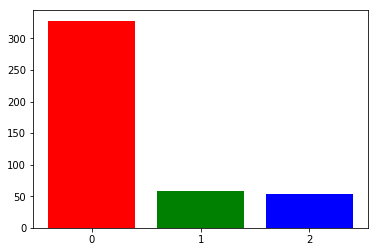

In [5]:
c = data.Cluster.value_counts()
plt.bar(range(k), c, color=colors)
plt.xticks(range(k))
plt.show()


 These are well-distributed enough to do our analysis, but it may be important
 to remember that most of the data is contained in the 0 cluster.

 # Cluster Visualization
 Having built our clusters, we conduct exploratory analysis of the data based
 upon those clusters to better understand what they might represent.

 To do so, we build a pairwise plot among the 6 quantitative predictors, which
 allows us to see how the clusters are stratified in the plot of each pair of
 variables. Along the diagonal are density plots for each variable. Those
 univariate density plots are also presented below in a clearer format.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


AttributeError: 'PairGrid' object has no attribute 'show'

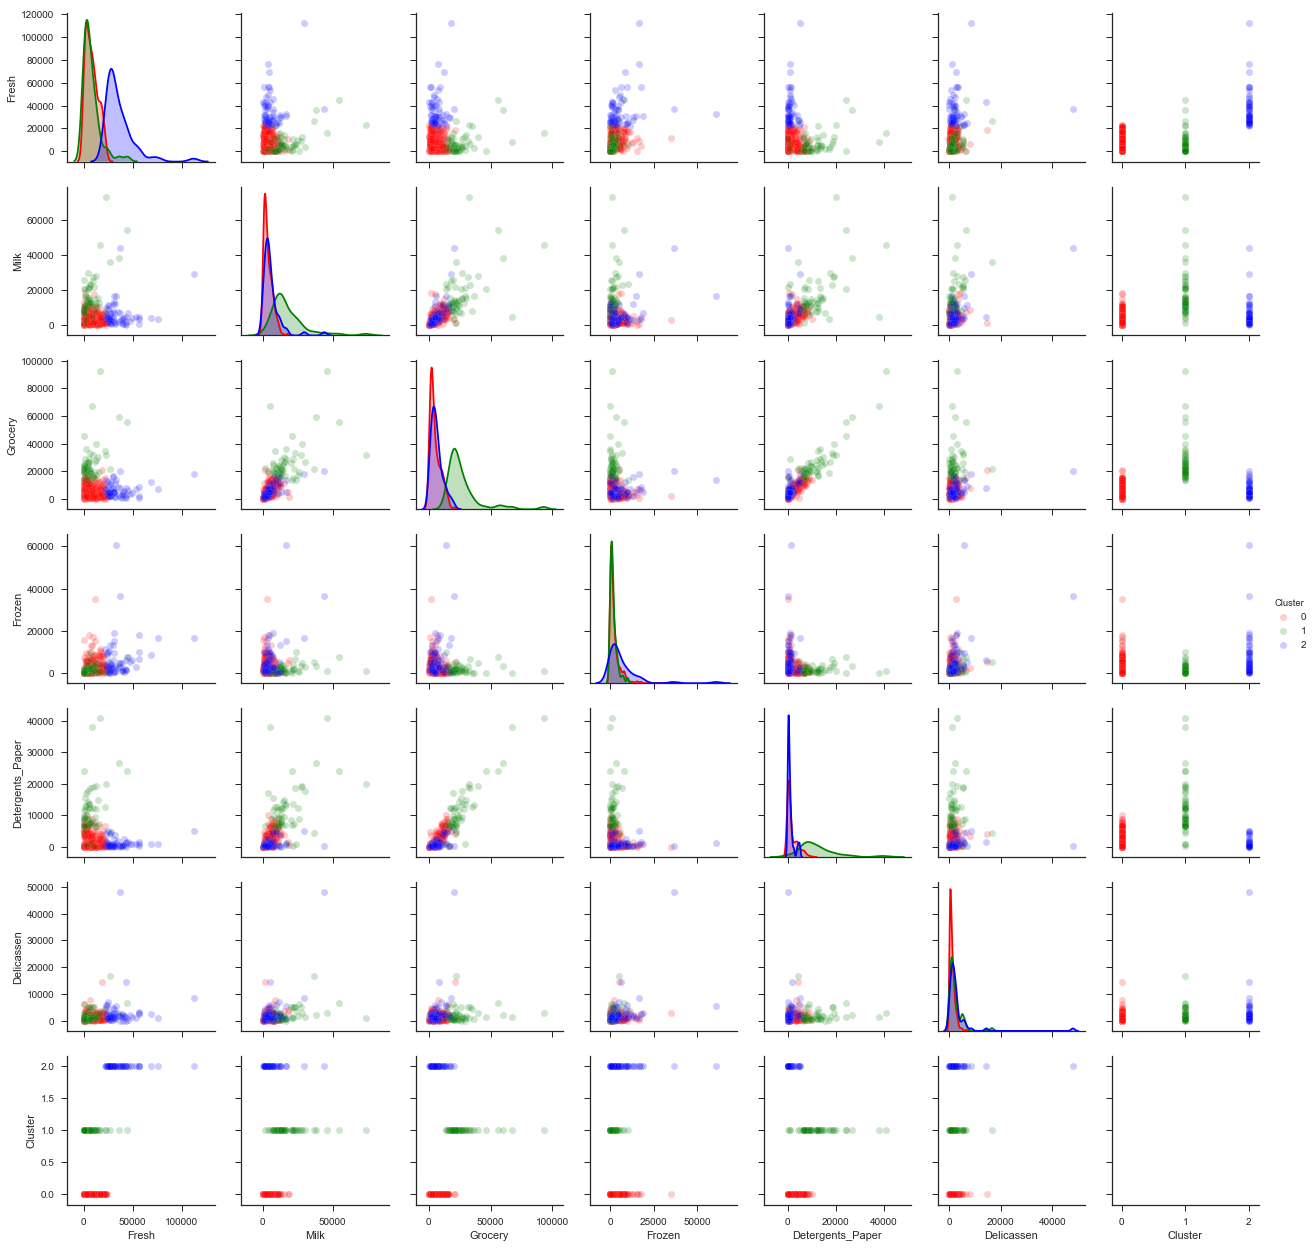

In [10]:
# Make pairplot
sns.set(style="ticks")
realcols = list(data)
realcols.remove("Cluster")
g = sns.pairplot(data.iloc[:, 2:9], 
    #vars = realcols,
    hue="Cluster", 
    diag_kind="kde", 
    diag_kws=dict(shade=True), 
    plot_kws=dict(alpha=.2),
    palette=colors)

g.show()


   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen Cluster
0  12669  9656     7561     214              2674        1338       0
1   7057  9810     9568    1762              3293        1776       0
2   6353  8808     7684    2405              3516        7844       0
3  13265  1196     4221    6404               507        1788       0
4  22615  5410     7198    3915              1777        5185       2


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


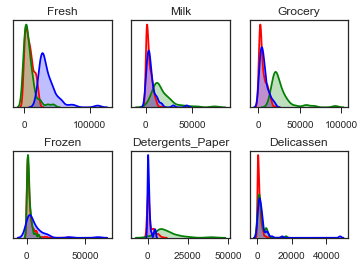

In [7]:
# Univariate plots
fig, axes = plt.subplots(2, 3)
qualdata = data.iloc[:, 2:]
print(qualdata.head())
for i in range(len(axes.flat)):
    ax = axes.flat[i]
    column = qualdata.iloc[:, i]
    for cluster in range(k):
        d = qualdata.loc[data["Cluster"] == cluster]
        sns.kdeplot(d.iloc[:,i], ax=ax, shade=True, legend=False, color=colors[cluster])
    ax.set(title = list(qualdata)[i])
    ax.get_yaxis().set_visible(False)

plt.subplots_adjust(hspace=0.5) # Set margins for subplots
fig.show()


 # Analyzing categorical data
 Note, however, that we also have some categorical data provided in the
 dataset, the channel and region. Let's see if our clusters differ along those
 dimensions as well.

 We'll start by examining the channel category.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


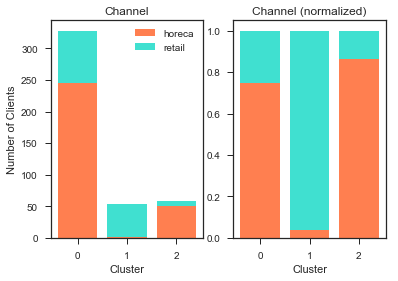

In [8]:
bars = np.empty((2,3))
normalbars = np.empty((2,3))
for i in range(k):
    clusterdata = data.loc[data.Cluster == i]
    bars[0][i] = (len(clusterdata.loc[data.Channel == 1]))
    bars[1][i] = (len(clusterdata.loc[data.Channel == 2]))
    normalbars[0][i] = (len(clusterdata.loc[data.Channel == 1])) / len(clusterdata)
    normalbars[1][i] = (len(clusterdata.loc[data.Channel == 2])) / len(clusterdata)

fig, (ax1, ax2) = plt.subplots(ncols=2)

h = ax1.bar(range(k), bars[0], color='#ff7f50')
r = ax1.bar(range(k), bars[1], bottom=bars[0], color='#40e0d0')
ax1.set_xticks(range(k))
ax1.set_title("Channel")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of Clients")
ax1.legend((h[0], r[0]), ("horeca", "retail"))

h = ax2.bar(range(k), normalbars[0], color='#ff7f50')
r = ax2.bar(range(k), normalbars[1], bottom=normalbars[0], color='#40e0d0')
ax2.set_xticks(range(k))
ax2.set_title("Channel (normalized)")
ax2.set_xlabel("Cluster")

fig.show()


 This chart shows pretty clearly how the model has stratified along the channel
 values. Cluster 1 is almost entirely retail sales, while clusters 0 and 2 are
 mostly horeca clients (hotel/restaurant/cafe).

 Now we'll do a similar analysis along Region.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


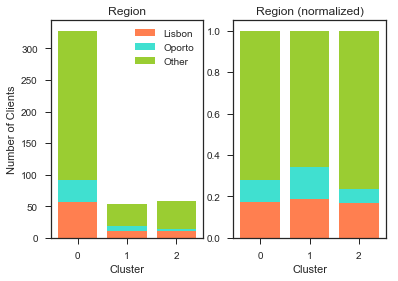

In [9]:
bars = np.empty((3,3))
normalbars = np.empty((3,3))
for i in range(k):
    clusterdata = data.loc[data.Cluster == i]
    for r in range(3):
        bars[r][i] = len(clusterdata.loc[data.Region == r+1])
        normalbars[r][i] = len(clusterdata.loc[data.Region == r+1]) / len(clusterdata)

fig, (ax1, ax2) = plt.subplots(ncols=2)
lisbon = ax1.bar(range(k), bars[0], color='#ff7f50')
oporto = ax1.bar(range(k), bars[1], bottom=bars[0], color='#40e0d0')
other = ax1.bar(range(k), bars[2], bottom=bars[0] + bars[1], color='#9acd32')

ax1.set_xticks(range(k))
ax1.set_title("Region")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of Clients")
ax1.legend((lisbon[0], oporto[0], other[0]), ("Lisbon", "Oporto", "Other"))

lisbon = ax2.bar(range(k), normalbars[0], color='#ff7f50')
oporto = ax2.bar(range(k), normalbars[1], bottom=normalbars[0], color='#40e0d0')
other = ax2.bar(range(k), normalbars[2], bottom=normalbars[0] + normalbars[1], color='#9acd32')

ax2.set_xticks(range(k))
ax2.set_title("Region (normalized)")
ax2.set_xlabel("Cluster")

plt.subplots_adjust(hspace=0.8)
fig.show()


 The model doesn't seem to depend as strongly on region - the relative
 proportions of each region are about the same in each cluster. This is
 particularly clear in the normalized bar chart above.

 # Cluster Descriptions
 We seem to have built some useful clusters here, so let's revisit our analyses
 and describe each one in terms of the data we've found.

 ## Cluster 0 (red)
 This cluster contains most of our data - over 300 records, around 75% of the
 clients. Looking at the pairplot, we notice that red points tend to cluster
 toward the bottom left corner. This is particularly evident in the plot of
 Fresh products vs Grocery products. These clients purchase fewer of most
 products overall than the other clusters. We can see these as our "base"
 clients: they don't buy a lot of anything in particular, but they consistently
 buy moderate amounts of everything. These are mostly hotels, restaurants, and
 cafes.

 ## Cluster 1 (green)
 These 50ish customers have a few habits that set them apart from the other
 clusters. They buy significantly more grocery products than either of the
 other clusters, and also tend to buy more products from the detergents and
 paper category. We can see from our qualitative data that members of cluster 1
 are overwhelmingly retail clients. Looking at the pairplot's univariate
 column, we can see that there is noticeably more variance among the members of
 cluster 1 than the others, a pattern which is most pronounced in the
 detergent/paper, grocery, and milk categories. This implies that a lot of our
 clients with unusual needs will be found in this cluster, and will be retail
 clients. We might expect that these clients will need more personalized
 customer service to meet their specific demands.

 ## Cluster 2 (blue)
 Our smallest cluster is composed of mostly hotel/restaurant/cafe clients, who
 most obviously deviate from the average behaviors in the fresh products
 category, where they buy far more than either of the other clusters. The
 cluster 2 client who demands the least fresh products still buys more than the
 average client in cluster 0 or 1. Except for a few outliers, most clients in
 cluster 2 buy about the same quantities of all other products - the variance
 is relatively small in every other product category. We can expect these
 clients to order a lot of fresh food, but also to be very consistent in other
 product categories, where their needs align very closely with the cluster 0
 clients.

 # Conclusion
 By conducting this cluster analysis of wholesale customers, a wholesale
 distributor can gain a greater understanding of what different kinds of
 clients they need to serve and how to best meet their needs. In particular,
 when they get a new client, they can make predictions to a considerable degree
 of accuracy regarding what the new client may need - even before they order
 it. As a result, they can be more efficient with their resources and more
 personal in their customer service to build strong relationships with their
 clients and gain and edge over their competition.